# Let's build a digit classifier!

## Load MNIST training and test set

In [1]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.MNIST(
    'data/',
    train = True,
    transform = ToTensor(),
    download = True)

test_data = datasets.MNIST(
    'data/',
    train = False,
    transform = ToTensor(),
    download = True)
    
print(len(training_data), len(test_data))

60000 10000


## Multi-layerPerceptron (Feed-Forward)

In [2]:
from torch import nn

class DigitClassifierMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.num_hidden = 8
        # layers with weights
        self.layers = nn.Sequential(  
          nn.Linear(28 * 28, self.num_hidden),
            nn.ReLU(),
            nn.Linear(self.num_hidden, 10),
            nn.LogSoftmax(dim=1))

    # input: [N, 1, 28, 28]
    def forward(self, input):
        # [N, 28 * 28]
        x = input.reshape(-1, 28 * 28)
        log_prob = self.layers(x)
        return log_prob

## Instantiate the model

In [3]:
digit_classifier_mlp = DigitClassifierMLP()

## Try it out

In [4]:
import torch
import random
from matplotlib import pyplot

def visualize(model, data):
    (image, correct_label) = random.choice(test_data)
    # image: 1 x 28 x 28
    print(f'Correct answer: {correct_label}')
    log_prob = model(image.reshape(1, 1, 28, 28))
    # log_prob: 1 x 10
    prob = log_prob[0].exp().tolist()
    fig, axes = pyplot.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(image[0])
    axes[1].bar(list(range(10)), prob)
    pyplot.show()

Correct answer: 7


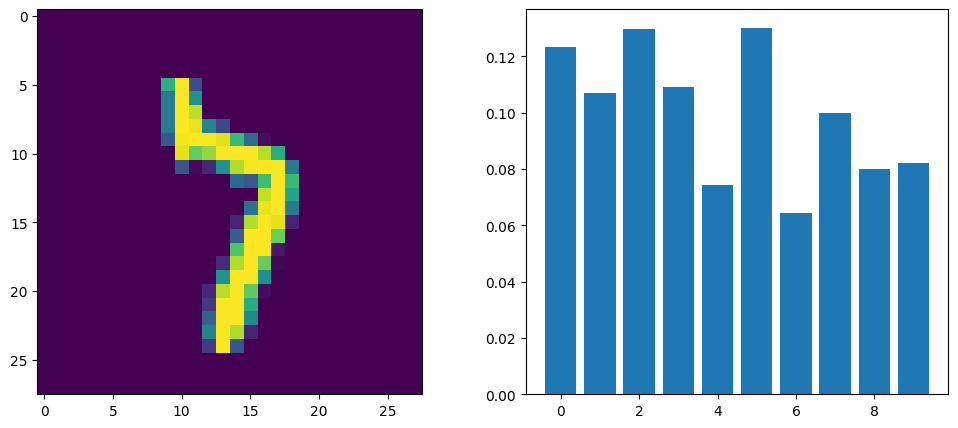

In [5]:
visualize(digit_classifier_mlp, test_data)

## Evaluate the model on test data

In [6]:
from torch.utils.data import DataLoader

def evaluate(model, data):
    cost_fn = nn.NLLLoss()
    data_loader = DataLoader(data, batch_size = 32)
    cost = 0.0
    correct = 0
    with torch.no_grad():
        for (images, correct_labels) in data_loader:
            log_prob = model(images)
            cost += len(images) * cost_fn(log_prob, correct_labels).item()
            correct += (log_prob.argmax(1) == correct_labels).sum().item()
    cost /= len(data)
    correct /= len(data)
    print(f'Evaluation cost: {cost:.8f} correct: {100 * correct:.2f}%')
    return cost

In [7]:
evaluate(digit_classifier_mlp, test_data)

Evaluation cost: 2.32791694 correct: 8.20%


2.3279169372558592

### Base cost for random guessing

In [8]:
import math
math.log(10)

2.302585092994046

## Train MLP

In [9]:
from torch import optim

def training_epoch(model, data):
    cost_fn = nn.NLLLoss()
    data_loader = DataLoader(data, batch_size=32, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr = 0.001)
    total_cost = 0.0
    for (images, labels) in data_loader:
        log_prob = model(images)
        cost = cost_fn(log_prob, labels)
        total_cost += len(images) * cost.item()
        # backpropagation
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
    total_cost /= len(data)
    print(f'Training cost: {total_cost:.8f}')
    return total_cost

In [10]:
def train(model):
    training_costs = []
    validation_costs = []
    for epoch in range(10):
        training_cost = training_epoch(model, training_data)
        validation_cost = evaluate(model, test_data)
        training_costs.append(training_cost)
        validation_costs.append(validation_cost)
    return training_costs, validation_costs

In [11]:
digit_classifier_mlp = DigitClassifierMLP()
training_costs, validation_costs = train(digit_classifier_mlp)

Training cost: 0.60388745
Evaluation cost: 0.35322639 correct: 90.08%
Training cost: 0.34414981
Evaluation cost: 0.32217096 correct: 90.97%
Training cost: 0.31952006
Evaluation cost: 0.31574443 correct: 91.08%
Training cost: 0.30616743
Evaluation cost: 0.30640035 correct: 91.52%
Training cost: 0.29903393
Evaluation cost: 0.29771764 correct: 91.73%
Training cost: 0.29223073
Evaluation cost: 0.29492399 correct: 91.86%
Training cost: 0.28826536
Evaluation cost: 0.29285077 correct: 91.95%
Training cost: 0.28489949
Evaluation cost: 0.29328012 correct: 91.87%
Training cost: 0.28168917
Evaluation cost: 0.29750490 correct: 91.93%
Training cost: 0.27845230
Evaluation cost: 0.28973195 correct: 91.90%


## Visualize training progress

In [12]:
def visualize_cost(training_costs, validation_costs):
    pyplot.plot(range(len(training_costs)), training_costs, label = 'training')
    pyplot.plot(range(len(validation_costs)), validation_costs, label = 'validation')
    pyplot.legend()
    pyplot.show()

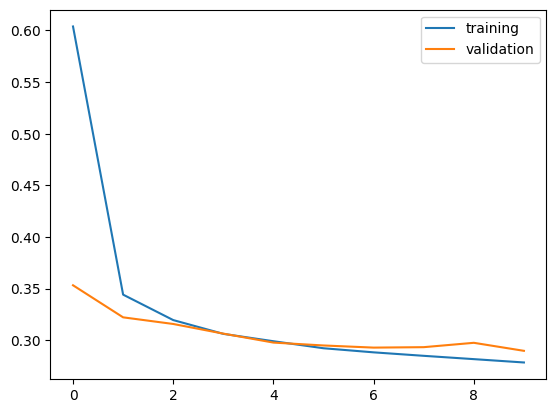

In [13]:
visualize_cost(training_costs, validation_costs)

## Try it out again

Correct answer: 5


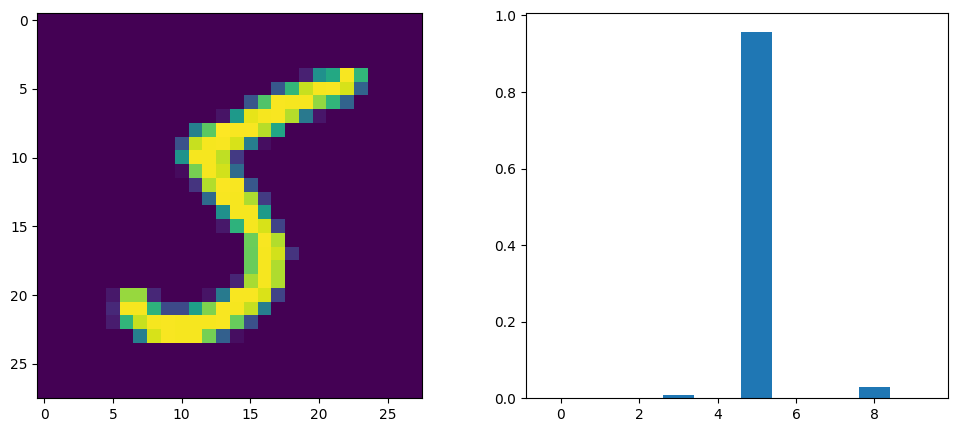

In [14]:
visualize(digit_classifier_mlp, test_data)

# Convolutional Neural Network

In [15]:
class DigitClassifierCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.channels_1 = 16
        self.channels_2 = 8
        self.num_hidden = 16
        self.layers = nn.Sequential(
            # 5^2 * 1 * 16 = 400 params
            nn.Conv2d(1, self.channels_1, 5, padding='same'),
            # N x 14 x 14 x 8
            nn.MaxPool2d(2),
            nn.ReLU(),
            # 5^2 * 16 * 8 = 3200 params
            nn.Conv2d(self.channels_1, self.channels_2, 5, padding='same'),
            # N x 7 x 7 x 8
            nn.MaxPool2d(2),
            nn.ReLU(),
            # N x 392
            nn.Flatten(1),
            # 392 * 16 = 6272 params
            nn.Linear(7 * 7 * self.channels_2, self.num_hidden),
            nn.ReLU(),
            nn.Linear(self.num_hidden, 10),
            nn.LogSoftmax(dim=1))

    # input: [N, 1, 28, 28]
    def forward(self, input):
        log_prob = self.layers(input)
        return log_prob

## Try out untrained CNN

In [16]:
digit_classifier_cnn = DigitClassifierCNN()

Correct answer: 8


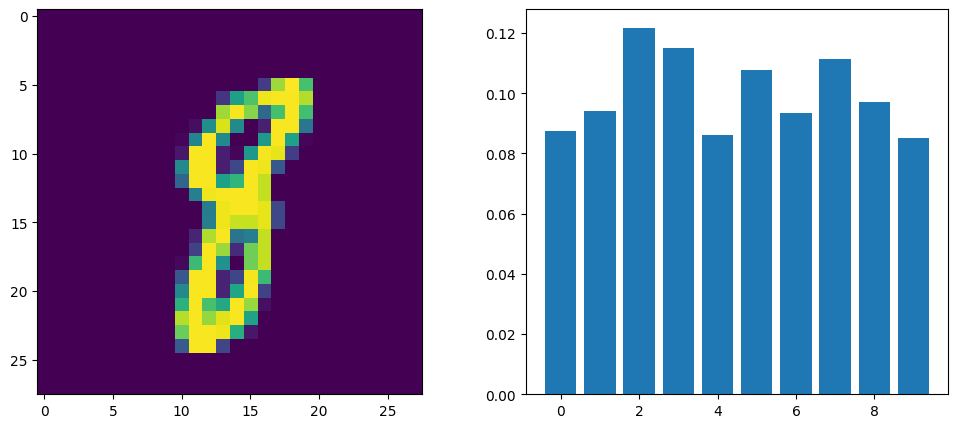

In [17]:
visualize(digit_classifier_cnn, test_data)

In [18]:
evaluate(digit_classifier_cnn, test_data)

Evaluation cost: 2.30921115 correct: 10.32%


2.3092111534118653

## Train CNN

In [19]:
digit_classifier_cnn = DigitClassifierCNN()
training_costs, validation_costs = train(digit_classifier_cnn)

Training cost: 0.24400593
Evaluation cost: 0.08114413 correct: 97.54%
Training cost: 0.08259212
Evaluation cost: 0.05928269 correct: 98.11%
Training cost: 0.06272884
Evaluation cost: 0.05316590 correct: 98.14%
Training cost: 0.05054973
Evaluation cost: 0.04783997 correct: 98.47%
Training cost: 0.04218800
Evaluation cost: 0.04705960 correct: 98.54%
Training cost: 0.03826152
Evaluation cost: 0.03790658 correct: 98.86%
Training cost: 0.03362240
Evaluation cost: 0.03763347 correct: 98.81%
Training cost: 0.02944307
Evaluation cost: 0.03268614 correct: 98.94%
Training cost: 0.02635194
Evaluation cost: 0.03471977 correct: 98.86%
Training cost: 0.02365053
Evaluation cost: 0.03335620 correct: 98.92%


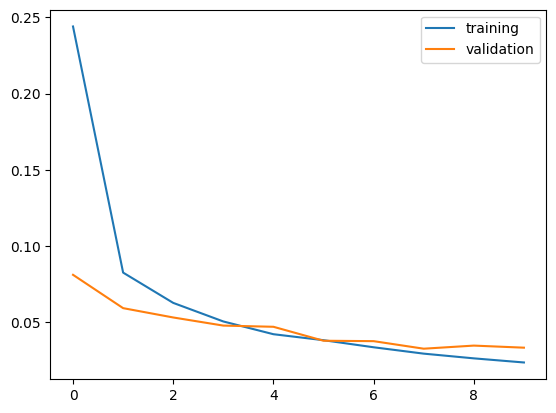

In [20]:
visualize_cost(training_costs, validation_costs)

## Try out trained CNN

Correct answer: 3


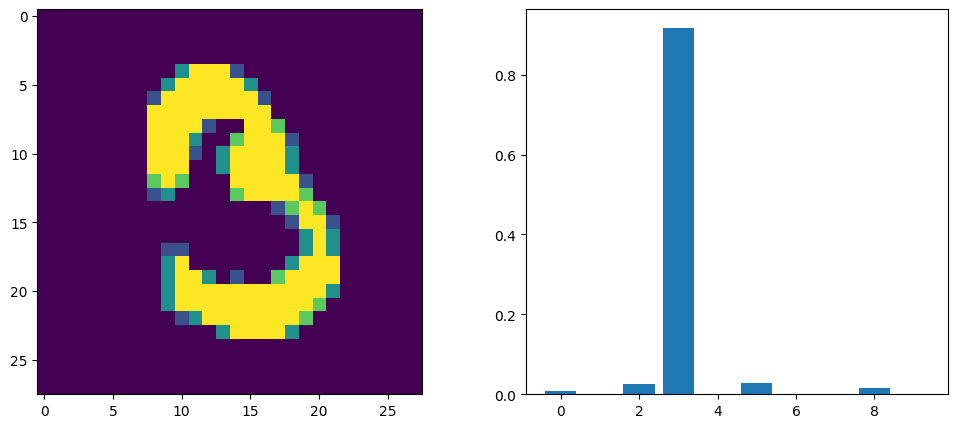

In [21]:
visualize(digit_classifier_mlp, test_data)